<a href="https://colab.research.google.com/github/AdamDlubak/Ki67/blob/master/Main_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

### Install packages

In [342]:
!pip install opencv-python
!pip install boolean.py
!pip install -U scikit-fuzzy
!pip install pyswarms

Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.6/dist-packages (0.4.0)


### Connect to Google Drive

In [343]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import Libraries

In [0]:
%matplotlib inline
import re
import cv2
import math
import pickle
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndimage
from matplotlib import pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import boolean
from IPython.display import HTML, display
import time
from tqdm import tnrange, tqdm_notebook
from time import sleep


import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
from pyswarms.utils.plotters.formatters import Mesher, Designer


### Variables

In [0]:
# images_folder = '/content/gdrive/My Drive/Praca Dyplomowa/Projekt/Graphics/'
images_folder = '/content/gdrive/My Drive/Praca Dyplomowa/Projekt/Color/'
files_folder = '/content/gdrive/My Drive/Praca Dyplomowa/Projekt/'

extension = '.jpg'
# image_name = 'flower_image_'
image_name = 'image_'

reduct_file = 'Reduct.p'
rules_file = 'Rules.p'

footprint = np.ones((3, 3))
footprint[1][1] = 3

# d_low = "Low Violet"
# d_average = "Average Violet"
# d_very = "Very Violet"

d_low = "Low Color"
d_average = "Average Color"
d_very = "Very Color"
d_results = [d_low, d_average, d_very]

low = "Low"
middle = "Middle"
high = "High"

sigma = 0.1
features_numbers = 6
set_min = 0 
set_max = 1
fuzzy_sets_precision = 0.000001
show_results = False

TRUE, FALSE, NOT, AND, OR, Symbol = algebra.definition()

## Fuzzy Components

In [0]:
features = []
feature_labels = []
x_arrange = np.arange(set_min, set_max, fuzzy_sets_precision)
names = [low, middle, high]


for i in range(0, features_numbers):
  feature_label = "F" + str(i)
  features.append(ctrl.Antecedent(np.arange(set_min, set_max, fuzzy_sets_precision), feature_label))
  feature_labels.append(feature_label)
  features[i].automf(names = names)


Decision = ctrl.Consequent(np.arange(set_min, set_max, fuzzy_sets_precision), 'Decision')
Decision.automf(names=[d_low, d_average, d_very])

## Read Images

#### Functions | Read Images

In [0]:
def read_images():

  images = []
  image_names = []
  image_decisions = []

  for images_type_folder in [d_low, d_average, d_very]:
    for name in listdir(images_folder + images_type_folder):
      file_path = images_folder + images_type_folder + "/" + name
      images.append(cv2.imread(file_path))
      image_names.append(name.replace(extension, ''))
      image_decisions.append(Decision[images_type_folder].label)
      
  return images, image_names, image_decisions

#### Read Images

In [0]:
images, image_names, image_decisions = read_images()

## Features Extraction

### Functions | Display Image

In [0]:
def print_image(image, title = ""):
  fig = plt.figure()
  fig.suptitle(title, fontsize = 13)
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def print_images(image_1, image_2, image_3, image_4, image_5, image_6, title_1 = "", title_2 = "", title_3 = "", title_4 = "", title_5 = "", title_6 = ""):
  fig = plt.figure(figsize=(18, 18))
  ax= plt.subplot(161)
  ax.set_title(title_1, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_1)
  
  ax = plt.subplot(162)
  ax.set_title(title_2, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_2)
  
  ax = plt.subplot(163)
  ax.set_title(title_3, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_3)
  
  ax = plt.subplot(164)
  ax.set_title(title_4, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_4)
 
  ax = plt.subplot(165)
  ax.set_title(title_5, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_5)

  ax = plt.subplot(166)
  ax.set_title(title_6, fontsize = 13)
  plt.axis('off')
  plt.imshow(image_6)
  
  plt.show() 
  

### Extract Features

#### Functions | Extract Features

In [0]:
def average_func(values):
  return np.average(values)

def threshold_binary(image, min_value, max_value):
  _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  return thresh

def split_into_rgb_channels(image):
  b, g, r = cv2.split(image)
  return r, g, b

def split_into_hsv_channels(image):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  h, s, v = cv2.split(hsv_image)
  return h, s, v

def prepare_image(image, image_type, width = 100, height = 30):
  
  resized_image = cv2.resize(image, (width, height))                   # Resize
  gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)         # Remove background
  
#   thresh = threshold_binary(gray_image, 20, 255)

  # Get R G B and H S V colors
  r_image, g_image, b_image = split_into_rgb_channels(resized_image) 
  h_image, s_image, v_image = split_into_hsv_channels(resized_image) 
  
  if image_type == "r":
    color_image = r_image
  elif image_type == "g":
    color_image = g_image
  elif image_type == "b":
    color_image = b_image
  elif image_type == "h":
    color_image = h_image
  elif image_type == "s":
    color_image = s_image
  else:
    color_image = v_image

    
  # Mean of pixel & neighbours
#   image_features = ndimage.generic_filter(color_image, average_func, footprint=footprint, mode='constant', cval=1)

  ## Sliding window
  image_features = []
  stepSize = 5
  (w_width, w_height) = (5, 5)
  for x in range(0, color_image.shape[0] + 1- w_width , stepSize):
     for y in range(0, color_image.shape[1] + 1- w_height, stepSize):
        image_features.append(np.average(color_image[x:x + w_width, y:y + w_height]))
  
#   image_features_without_bg = np.copy(image_features)
#   for x in range(len(image_features)):
#     for y in range(len(image_features[0])):
#       if thresh[x][y] == 255:
#         image_features_without_bg[x][y] = 255

#   print_images(resized_image, gray_image, thresh, color_image, image_features, image_features_without_bg, "Resized Image", "Grey Image", "Background removing", "Color Image", "Image Features", "Image Features with threshold")
  
  # Flatten
#   features_without_bg = image_features_without_bg.ravel()
  
  # Remove background values
#   features_without_bg = list(filter(lambda x: x != 255, features_without_bg))
#   return [sum(features_without_bg) / float(len(features_without_bg))]
#   return features_without_bg
  return image_features

In [0]:
def extract_features_from_image(image, image_decision, image_name):
  results = prepare_image(image, "r")
  decision_table = pd.DataFrame({features[0].label: results})

  results = prepare_image(image, "g")
  decision_table[features[1].label] = results  

  results = prepare_image(image, "b")
  decision_table[features[2].label] = results  

  results = prepare_image(image, "s")
  decision_table[features[3].label] = results  
  
  results = prepare_image(image, "h")
  decision_table[features[4].label] = results  
  
  results = prepare_image(image, "v")
  decision_table[features[5].label] = results  

  image_column = np.full(decision_table.shape[0], image_name)
  decision_table['Image'] = image_column  

  decision_column = np.full(decision_table.shape[0], image_decision)
  decision_table['Decision'] = decision_column  
  
  decision_table['Predicted Value'] = "" 

  return decision_table

In [0]:
def extract_features(images):

  features_array = []
  features_table = pd.DataFrame()

  for idx, image in enumerate(images):
    features_array.append(extract_features_from_image(image, image_decisions[idx], image_names[idx]))
  
  features_table = pd.concat(features_array).reset_index(drop=True)

  if show_results:
    display(features_table)
    
  return features_table

#### Extract Features

In [0]:
features_table = extract_features(images)

In [354]:
features_table.iloc[121]

F0                        193.04
F1                          18.8
F2                         19.08
F3                        230.32
F4                             0
F5                        193.04
Image                    image_2
Decision           Average Color
Predicted Value                 
Name: 121, dtype: object

### Normalize Features

#### Features | Normalize Features

In [0]:
def normalize_features(features_table, features):

  for x in features:
    features_table[x.label] = (features_table[x.label]-features_table[x.label].min())/(features_table[x.label].max()-features_table[x.label].min())

  if show_results:
    display(features_table)
    
  return features_table

#### Normalize Features 

In [0]:
features_table = normalize_features(features_table, features)

## Fuzzyfication

### Functions | Fuzzyfication

In [0]:
def gauss_left(x, mean, sigma):
  y = np.zeros(len(x))
  idx = x <= mean
  y[idx] = 1 - fuzz.gaussmf(x[idx], mean, sigma)
  return y

def gauss_right(x, mean, sigma):
  y = np.zeros(len(x))
  idx = x >= mean
  y[idx] = 1 - fuzz.gaussmf(x[idx], mean, sigma)
  return y

def numbers_to_row_sets(idx, values, sigma, x_arrange):
  

  values = values.values
  return_array = []
  mean = values.mean()

  features[idx][low] =  gauss_left(x_arrange, mean, sigma)
  features[idx][middle] = fuzz.gaussmf(x_arrange, mean, sigma)
  features[idx][high] = gauss_right(x_arrange, mean, sigma)
 
  for x in values:
    middle_value = fuzz.gaussmf(x, mean, sigma)
    if x <= mean:
      low_value = 1 - fuzz.gaussmf(x, mean, sigma)
    else:
      low_value = 0

    if x >= mean:
      high_value = 1 - fuzz.gaussmf(x, mean, sigma)
    else:
      high_value = 0   
    
    max_value = high_value
    return_value = features[idx][high].label

    if middle_value > max_value:
      max_value = middle_value
      return_value = features[idx][middle].label

    if low_value > max_value:
      max_value = low_value
      return_value = features[idx][low].label

    return_array.append(return_value)
    
  return return_array

def present_fuzzy_features_charts(features):
  for x in features:
    x.view()
    
def fuzzify(features_table, features):
  for idx, x in enumerate(features):
    features_table[x.label] = numbers_to_row_sets(idx, features_table[x.label], sigma, x_arrange)

  if show_results:
    present_fuzzy_features_charts(features)
    display(features_table)
  
  return features_table

### Fuzzyfication

In [0]:
features_table = fuzzify(features_table, features)

##  Inconsistencies Removing

### Functions | Inconsistencies Removing

In [0]:
def get_occurence_of_rows(df, remove_columns):
  df = df.drop(remove_columns, axis=1, inplace=False)
  df = df.groupby(df.columns.tolist(),as_index=False).size().reset_index(name="Occurence")
  return df

def get_certain_decision_rows(features_occurence, features_decisions_occurence):
  features_decision_numbers_ones = features_occurence.loc[features_occurence['Occurence'] == 1].copy()

  for index, row in features_decision_numbers_ones.iterrows():
    for idx, row_with_decision in features_decisions_occurence.iterrows():
      if (row[feature_labels].values == row_with_decision[feature_labels].values).all():   
        features_decision_numbers_ones.at[index, 'Decision'] = features_decisions_occurence.loc[idx, 'Decision']
        
  return features_decision_numbers_ones.drop(['Occurence'], axis=1, inplace=False)

def get_number_of_clear_decision(features_occurence, features_decisions_occurence):
  
  features_certain_decision = get_certain_decision_rows(features_occurence, features_decisions_occurence)
  
  tmp_table = pd.merge(features_decisions_occurence, features_certain_decision, 
                       how='inner', on=feature_labels)
  
  if 'Decision_y' in tmp_table.columns:
    tmp_table = tmp_table.drop(['Decision_y'], axis=1).rename(index=str, columns={"Decision_x": "Decision", "Occurence_x": "Occurence"})


  number_of_clear_decision = pd.DataFrame(tmp_table.groupby(['Decision'], as_index=False)['Occurence'].agg('sum'))
  
  return number_of_clear_decision

def solve_conflicts(number_of_conflicts_decision, problems_to_solve):

  for index, row in number_of_conflicts_decision.iterrows():
    new_df = pd.DataFrame(columns={"Decision", "Probability"})

    for index_2, row_2 in problems_to_solve.iterrows():
      if (row[feature_labels].values == row_2[feature_labels]).all():

        try:
          occurence = (number_of_clear_decision.loc[number_of_clear_decision['Decision'] == row_2[['Decision']].values[0]]).values[0][1]
        except:
          occurence = 0

        probability = occurence / len(features_table)
        new_df = new_df.append({'Decision': row_2[['Decision']].values, 'Probability': probability}, ignore_index=True)

    new_value = new_df.loc[new_df['Probability'].idxmax()]['Decision'][0]
  
  
    for idx, row_decision_table in features_decisions_occurence.iterrows():
      if (row[feature_labels].values == row_decision_table[feature_labels]).all():
        features_decisions_occurence.loc[idx, 'Decision'] = new_value
  
  return features_decisions_occurence

In [0]:
def inconsistencies_removing(features_table):

  features_decisions_occurence = get_occurence_of_rows(features_table, ['Image'])
  if show_results:
    display(features_decisions_occurence)

  features_occurence = get_occurence_of_rows(features_table, ['Image', 'Decision'])
  if show_results:
    display(features_occurence)

  number_of_conflicts_decision = features_occurence[features_occurence.Occurence > 1]
  if show_results:
    print("\nW tylu konflikach występuje:")
    display(number_of_conflicts_decision)

  number_of_clear_decision = get_number_of_clear_decision(features_occurence, features_decisions_occurence)
  if show_results:
    print("\nTyle jest wystąpień takich czystych decyzji:")
    display(number_of_clear_decision)

  problems_to_solve = pd.merge(features_decisions_occurence, number_of_conflicts_decision, how='inner', on=feature_labels).drop(['Occurence_x', "Occurence_y"], axis = 1)
  if show_results:
    print("\nTe problemy należy rozwiązać:")
    display(problems_to_solve)

  features_decisions_occurence = solve_conflicts(number_of_conflicts_decision, problems_to_solve)
  decision_table = features_decisions_occurence.drop(['Occurence'], axis = 1).drop_duplicates(keep='first', inplace=False)
  if show_results:
    print("Tablica decyzyjna po usunięciu duplikatów i niespójności")
    display(decision_table)  

  return decision_table

### Inconsistencies Removing

In [0]:
features_table = inconsistencies_removing(features_table)

## Generate Reduct

In [0]:
def get_reduct(features_table):
  
  reduct = []
  
  features_table = features_table.drop(['Decision'], axis=1)
  features_table = features_table.reset_index(drop=True)
  results = np.zeros((len(features_table), len(features_table), len(features_table.columns)))


  for index_i, i in features_table.iterrows():
    for index_j, j in features_table.iterrows():
      if index_i > index_j:
        tmp_entity = np.zeros(len(features_table.columns))
        for idx, x in enumerate(range(0, len(i.values))):
          if i[x] != j[x]:
            tmp_entity[idx] = True
        results[int(index_i), int(index_j)] = tmp_entity
        
  while True:
    reduct_counter = np.zeros(len(features_table.columns))

    for i in results:
      for j in i:
        for index_k, k in enumerate(j):
          if k != 0:
            reduct_counter[index_k] = reduct_counter[index_k] + 1

    if all(item == 0 for item in reduct_counter):
      break
    
    winner = np.argwhere(reduct_counter == np.amax(reduct_counter)).flatten().tolist()

    new_to_reduct = np.random.choice(winner)
    reduct.append(new_to_reduct)

    for index_i, i in enumerate(results):
      for index_j, j in enumerate(i):
        if 1 == j[new_to_reduct]:
          results[int(index_i)][int(index_j)] = np.zeros(len(features_table.columns))
        
    if all(item == 0 for item in reduct_counter):
      break
  
  if show_results:
    print("Reduct - Index of features: " + str(reduct))

  return reduct

In [0]:
reduct = get_reduct(features_table)

### Introduce Reduct

In [0]:
def introduce_reduct(features_table, reduct):
  decision_table_after_reduct = features_table[features_table.columns[reduct]]
  decision_table_after_reduct['Decision'] = features_table['Decision']
  decision_table_after_reduct = decision_table_after_reduct.reset_index(drop=True)
  
  if show_results:
    display(decision_table_after_reduct)

  return decision_table_after_reduct

In [365]:
features_table = introduce_reduct(features_table, reduct)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Implicants matrix

#### Symetric Discernibility Matrix & Implicants matrix

In [0]:
def generate_symetric_discernibility_matrix(features_table):

  features_table = features_table.drop(['Decision'], axis=1)

  symetric_discernibility_matrix = np.zeros((len(features_table), len(features_table), len(reduct)))


  for index_i, i in features_table.iterrows():
    for index_j, j in features_table.iterrows():
      if index_i != index_j:           # Tutaj jest różnica - nie ma ">" jest za to != tak aby uzyskać symetryczną tablicę 
        tmp_entity = np.zeros(len(reduct))
        for idx, x in enumerate(range(0, len(i.values))):
          if i[x] != j[x]:
            tmp_entity[idx] = True
        symetric_discernibility_matrix[int(index_i), int(index_j)] = tmp_entity

  return symetric_discernibility_matrix

def generate_implicants_matrix(symetric_discernibility_matrix, reduct, features_table):
  M_matrix = np.zeros((len(symetric_discernibility_matrix), len(symetric_discernibility_matrix), len(reduct)))

  for index_i, i in features_table.iterrows():
    for index_j, j in features_table.iterrows():
      if i['Decision'] != j['Decision']:
        M_matrix[index_i][index_j] = symetric_discernibility_matrix[index_i][index_j]

  return M_matrix

symetric_discernibility_matrix = generate_symetric_discernibility_matrix(features_table)
implicants_matrix = generate_implicants_matrix(symetric_discernibility_matrix, reduct, features_table)

## Get Rules

### Functions | Define implicants

In [0]:
def get_feature_names(features_table):
  feature_names = np.asarray(features_table.columns)[0:-1]

  if show_results:
    print(feature_names)
    
  return feature_names

def generate_implicants(implicants_matrix, feature_names):
  
  implicants = []

  for index_i, i in enumerate(implicants_matrix):
    new_expression = ""
    for index_j, j in enumerate(i):
      new_subexpression = "("
      any_value = False
      for index_k, k in enumerate(j):
        if k == True:
          any_value = True
          new_subexpression = new_subexpression + feature_names[index_k] + " | "
      if any_value:
        new_subexpression = new_subexpression[:-3] + ")"
        if new_expression != "":
          new_expression = new_expression + " & " + new_subexpression
        else:
          new_expression = new_subexpression
    simplified_implicant = algebra.parse(new_expression).simplify()
    implicants.append(simplified_implicant)

    if show_results:
      print(implicants)
    
  return implicants



### Generate rules from implicants

#### Functions | Generate rules from implicants

In [0]:
def get_index_of_rules_table(features_table):

  rules_table = []
  
  for x in features_table['Decision'].drop_duplicates():
    rules_table.append(features_table.loc[features_table['Decision'] == x].index.tolist())
  
  if show_results:
    print("Connection between implicants and rules:" + str(rules_table))    
  
  return rules_table
  
def modify_implicants(elem, implicant_idx):
  
  if type(elem) == AND:

    for idx_x, x in enumerate(elem.args):
      if idx_x == 0:
        small_rule = modify_implicants(x, implicant_idx)
      else:
        small_rule = small_rule & modify_implicants(x, implicant_idx)
  
  if type(elem) == OR:
    
    for idx_x, x in enumerate(elem.args):
      if idx_x == 0:
        small_rule = modify_implicants(x, implicant_idx)
      else:
        small_rule = small_rule | modify_implicants(x, implicant_idx)
  
  if type(elem) == Symbol:
    implicant_column_name = str(elem)
    implicant_column_number = str(elem)[1:]
    antecedent_part = features[int(implicant_column_number)][features_table.loc[implicant_idx][implicant_column_name]]
    return antecedent_part

  return small_rule 
  
def modify_implicants_for_rules(implicants):
  
  new_implicants = []

  for idx_i, i in enumerate(implicants):
    new_implicants.append(modify_implicants(i, idx_i))

  if show_results:
    print(new_implicants)

  return new_implicants
  
def generate_rule_antecedents(index_of_rules_table, new_implicants):
  
  rule_antecedents = []
  for x in index_of_rules_table:
    for idx, y in enumerate(x):
      if idx == 0:
        tmp_rule = new_implicants[y]
      else:
        tmp_rule = tmp_rule | new_implicants[y]
    rule_antecedents.append(tmp_rule)
  
  return rule_antecedents  
  
def generate_rules(rule_antecedents, d_results):
  rules = []
  for idx, x in enumerate(rule_antecedents):
    rules.append(ctrl.Rule(x, Decision[d_results[idx]]))

  return rules  

#### Generate rules from implicants

In [0]:
algebra = boolean.BooleanAlgebra()

feature_names = get_feature_names(features_table)
implicants = generate_implicants(implicants_matrix, feature_names)
index_of_rules_table = get_index_of_rules_table(features_table)
new_implicants = modify_implicants_for_rules(implicants)
rule_antecedents = generate_rule_antecedents(index_of_rules_table, new_implicants)
rules = generate_rules(rule_antecedents, d_results)

### Make Prediction

0.24727083763721874


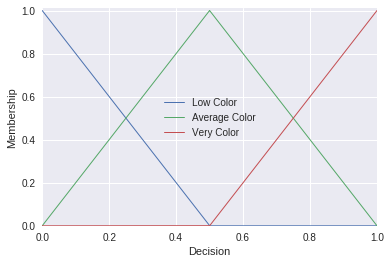

In [376]:
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

tipping.input['F5'] = 0.299489
tipping.input['F3'] = 0.122455
tipping.input['F2'] = 0.884941
tipping.input['F4'] = 0.000000

tipping.compute()

print(tipping.output['Decision'])
Decision.view(sim=tipping)

## Transfer Results

### Pickle Data

In [0]:
pickle.dump( [rule1, rule2, rule3], open( files_folder + rules_file, "wb" ) )

In [0]:
pickle.dump( parameter_names, open( files_folder + reduct_file, "wb" ) )